In [1]:
import os
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from tifffile import imwrite
from PIL import Image
from tqdm import tqdm
from copy import deepcopy
import json
from skimage.color import gray2rgb


In [2]:
savedir = "data_level_1/"
savedir_adata = os.path.join(savedir, "adata")
savedir_imgs = os.path.join(savedir, "dapi")
savedir_adata, savedir_imgs

('data_level_1/adata', 'data_level_1/dapi')

In [3]:
adata = sc.read_h5ad("/data/projects/robin/segmentation/xenium_outs/merged_processed.h5ad")
adata_nichepca = sc.read_h5ad("/data/projects/Behnam/xenium-cgn/notebooks/06_domain_identification/adata/adata_nichepca_with_domain_tuned_v1.h5ad")

In [4]:
adata.obs['Biopsy_ID'] = adata_nichepca.obs['Biopsy_ID']
adata.obs['sample'] = adata_nichepca.obs['sample']
adata.obs['label'] = adata_nichepca.obs['label']
adata.obs['nichepca_domain'] = adata_nichepca.obs['nichepca_domain']
adata.obs['nichepca_domain_tuned'] = adata_nichepca.obs['nichepca_domain_tuned']
adata.obs['nichepca_glom_no'] = adata_nichepca.obs['nichepca_glom_no']

In [5]:
adata.obs["Slide_ID"].value_counts()

Slide_ID
0011216    502183
0011287    447138
0011695    428990
0011546    407882
0011707    396753
0018775    380044
0011284    360671
0011762    307083
Name: count, dtype: int64

In [6]:
sample_set = adata.obs["sample"].astype(str).unique()
sample_set.sort()
sample_set

array(['X1', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17',
       'X18', 'X19', 'X2', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25',
       'X26', 'X27', 'X28', 'X29', 'X3', 'X30', 'X31', 'X32', 'X33',
       'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X4', 'X40', 'X41',
       'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X5',
       'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58',
       'X59', 'X6', 'X60', 'X61', 'X62', 'X63', 'X7', 'X8', 'X9', 'nan'],
      dtype=object)

In [7]:
def cap(val, index = 0):
    if val < 0:
        val = 0
    # elif val > img.shape[index]:
    #     val = img.shape[index]
    return val

LEVEL = 1

In [ ]:
for sample in tqdm(sample_set):
    
    sub = adata[adata.obs["sample"]==sample]
    ID = sub.obs.Slide_ID.unique()[0]
    scale_factor = sub.uns["spatial"][ID]["scalefactors"][f"tissue_dapi_LEVEL{LEVEL}_scalef"]
    #ax=sc.pl.embedding(sub, basis="spatial", s=20, show=False)
    ylim=(sub.obsm["spatial"][:,1].min()-350, sub.obsm["spatial"][:,1].max()+350)
    xlim=(sub.obsm["spatial"][:,0].min()-350, sub.obsm["spatial"][:,0].max()+350)
    ylim = tuple(np.array(ylim)*scale_factor)
    xlim = tuple(np.array(xlim)*scale_factor)
    ylim = tuple([cap(val, 1) for val in ylim])
    xlim = tuple([cap(val, 0) for val in xlim])

    #plt.show()
    #plt.clf()

    img = sub.uns["spatial"][ID]["images"][f"dapi_LEVEL{LEVEL}"]
    cut_coords = np.concatenate([xlim, ylim])
    img_cropped = img[int(cut_coords[2]): int(np.ceil(cut_coords[3])),\
                     int(cut_coords[0]): int(np.ceil(cut_coords[1]))]

    sub.uns["spatial"][ID]["images"][f"dapi_LEVEL{LEVEL}"+"_cropped"] = img_cropped
    sub.uns["spatial"][ID]["scalefactors"]["tissue_dapi_LEVEL{LEVEL}_cropped_scalef"] = 1

    sub.obsm["spatial"][:,0] = sub.obsm["spatial"][:,0]*scale_factor-int(cut_coords[0])
    sub.obsm["spatial"][:,1] = sub.obsm["spatial"][:,1]*scale_factor-int(cut_coords[2])

    keys = list(sub.uns["spatial"].keys())
    newdict = deepcopy(sub.uns["spatial"])
    for key in keys:
        if key!=ID:
            del newdict[key]
    sub.uns["spatial"] = newdict
    
    img_to_save = Image.fromarray((sub.uns["spatial"][ID]["images"][f"dapi_LEVEL{LEVEL}"+"_cropped"]*255).astype(np.uint8))
    im_arr = (sub.uns["spatial"][ID]["images"][f"dapi_LEVEL{LEVEL}"+"_cropped"]*255).astype(np.uint8)

    img_to_save.save(os.path.join(savedir_imgs, f"{sample}.png"),"PNG")
    imwrite(os.path.join(savedir_imgs, f"{sample}.tiff"), im_arr)
    sub.write(os.path.join(savedir_adata, f"{sample}.h5ad"))

  0%|          | 0/64 [00:00<?, ?it/s]/tmp/ipykernel_86394/3933080795.py:25: ImplicitModificationWarning: Trying to modify attribute `.obsm` of view, initializing view as actual.
  sub.obsm["spatial"][:,0] = sub.obsm["spatial"][:,0]*scale_factor-int(cur_coords[0])
  2%|▏         | 1/64 [03:19<3:29:23, 199.43s/it]/tmp/ipykernel_86394/3933080795.py:25: ImplicitModificationWarning: Trying to modify attribute `.obsm` of view, initializing view as actual.
  sub.obsm["spatial"][:,0] = sub.obsm["spatial"][:,0]*scale_factor-int(cur_coords[0])
  3%|▎         | 2/64 [05:44<2:52:44, 167.16s/it]/tmp/ipykernel_86394/3933080795.py:25: ImplicitModificationWarning: Trying to modify attribute `.obsm` of view, initializing view as actual.
  sub.obsm["spatial"][:,0] = sub.obsm["spatial"][:,0]*scale_factor-int(cur_coords[0])


In [9]:
print("Done")

Done


In [89]:
he_image_dir = "data_level_1/he_registered_old/"
sample = 'X1'

In [90]:
adata_i = sub
he_image = plt.imread(he_image_dir + f'{sample}.tiff')

In [91]:
slide_id = adata_i.obs['Slide_ID'][0]
adata_i.uns['spatial'][slide_id]['images']['he_downscaled_aligned'] = he_image  
adata_i.uns['spatial'][slide_id]['scalefactors']['tissue_he_downscaled_aligned_scalef'] = 1

/tmp/ipykernel_81886/1894205243.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slide_id = adata_i.obs['Slide_ID'][0]


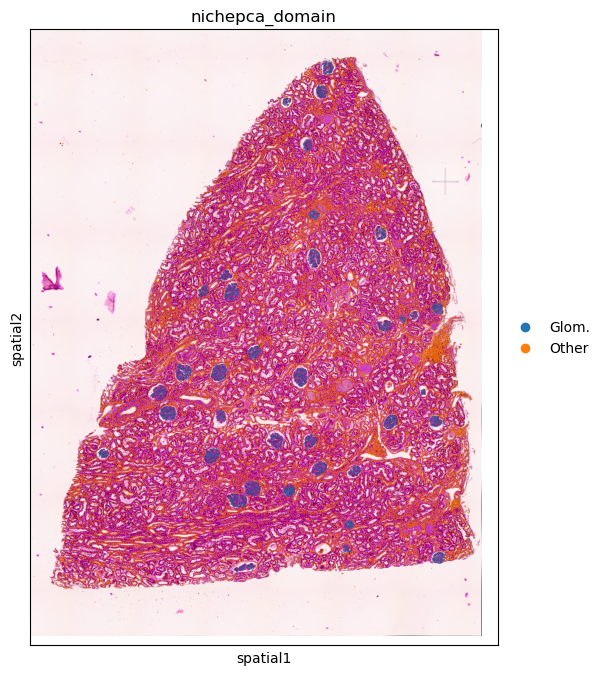

In [94]:
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.spatial(adata_i,
              library_id = slide_id,
              img_key = 'he_downscaled_aligned',
              color = 'nichepca_domain',
              size = .2,
              ax = ax,
              show = True)